# Map / Region Preparation

NW = -29.94800400, -51.26576000 	NE = -29.94800400, -51.04169000
SW = -30.24464000, -51.26576000 	SE = -30.24464000, -51.04169000
Width (Longitude):	21.52401857 km /	 0.22407000 deg
Height (Latitude):	32.98441826 km /	 0.29663600 deg


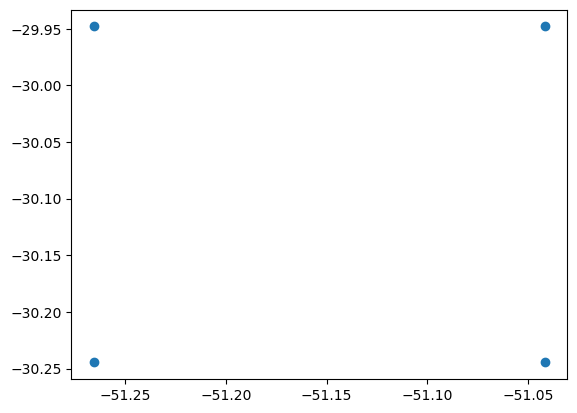

In [1]:
import json
import requests
from remote_requests import get_bounding_box
from features.geostructures import BoundingBox
from features.feature_factory import FeatureFactory
import matplotlib.pyplot as plt

# Make the bounding box
whole_region_bbox = BoundingBox.from_points(get_bounding_box())
whole_region_bbox.summary()
plt.scatter(
    [whole_region_bbox.north_east.longitude, whole_region_bbox.north_west.longitude, whole_region_bbox.south_east.longitude, whole_region_bbox.south_west.longitude],
    [whole_region_bbox.north_east.latitude, whole_region_bbox.north_west.latitude, whole_region_bbox.south_east.latitude, whole_region_bbox.south_west.latitude]
)
plt.show()

Matrix will be 66 cells high and 43 cells wide.


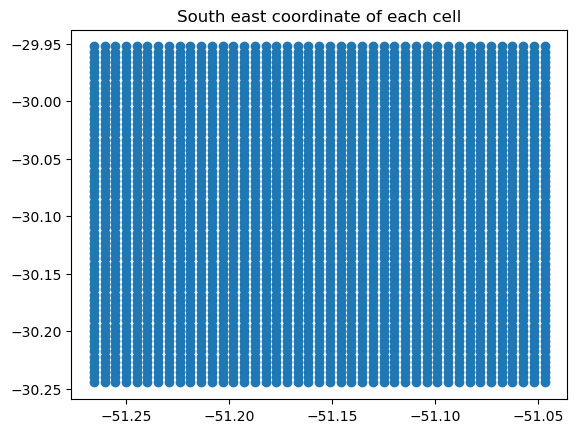

In [2]:
# Calculate the south east (base) points
DESIRED_REGION_SIZE_KM = 0.5
cells_height:float = round(whole_region_bbox.height / DESIRED_REGION_SIZE_KM)
cells_width:float = round(whole_region_bbox.width / DESIRED_REGION_SIZE_KM)

print(f'Matrix will be {cells_height} cells high and {cells_width} cells wide.')
bases_x = [((x / cells_width) * (whole_region_bbox.south_east.longitude - whole_region_bbox.south_west.longitude)) + whole_region_bbox.south_west.longitude
              for x in range(cells_width) for y in range(cells_height)]
bases_y = [((y / cells_height) * (whole_region_bbox.north_west.latitude - whole_region_bbox.south_west.latitude)) + whole_region_bbox.south_west.latitude
              for x in range(cells_width) for y in range(cells_height)]
plt.scatter(
    bases_x,
    bases_y
)
plt.title("South east coordinate of each cell")
plt.show()

Difference in latitude is 0.00449448
Difference in longitude is 0.00521093


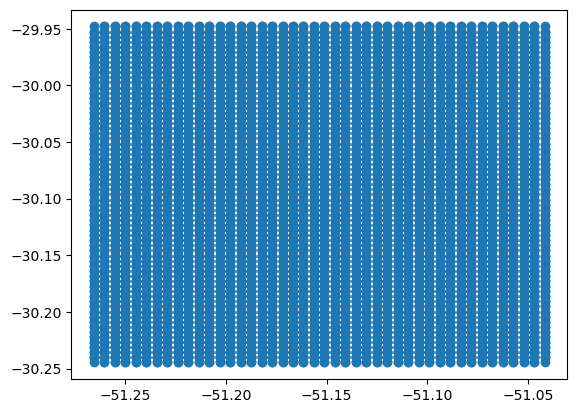

In [3]:
# Calculate the bounds for each cell
from features.geostructures import Coordinates


difference_in_latitude = bases_y[1] - bases_y[0]
difference_in_longitude = bases_x[cells_height + 1] - bases_x[0]
print(f'Difference in latitude is {difference_in_latitude:.8f}')
print(f'Difference in longitude is {difference_in_longitude:.8f}')
cells = [
    [ 
        BoundingBox(
            south_west = Coordinates(
                latitude=(y * difference_in_latitude) + whole_region_bbox.south_west.latitude,
                longitude=(x * difference_in_longitude) + whole_region_bbox.south_west.longitude
            ),
            north_east = Coordinates(
                latitude=((y + 1) * difference_in_latitude) + whole_region_bbox.south_west.latitude,
                longitude=((x + 1) * difference_in_longitude) + whole_region_bbox.south_west.longitude
            )
        ) for y in range(cells_height)
    ] for x in range(cells_width)
]

bounds_x = []
bounds_y = []
for x in range(cells_width):
    for y in range(cells_height):
        cell = cells[x][y]
        bounds_x.append(cell.north_east.longitude)
        bounds_x.append(cell.south_east.longitude)
        bounds_x.append(cell.south_west.longitude)
        bounds_x.append(cell.north_west.longitude)

        bounds_y.append(cell.north_east.latitude)
        bounds_y.append(cell.south_east.latitude)
        bounds_y.append(cell.south_west.latitude)
        bounds_y.append(cell.north_west.latitude)

plt.scatter(
    bounds_x,
    bounds_y
)
plt.show()

In [4]:
# Create factory
from features.factory import Factory

factory = Factory(regions=cells, domain=whole_region_bbox, cell_size = DESIRED_REGION_SIZE_KM)
factory.summary()

print(f'Checking get_location_cell...', end=' ')
for x in range(cells_width):
    for y in range(cells_height):
        assert factory.get_location_cell(cells[x][y].center) == (x, y)
print('OK')

Total 2838 regions
43 regions wide
66 regions tall
Checking get_location_cell... OK


# Dataset Preparation

## Dataset params

In [5]:
N = 7                           # Number of days to look back at
F = 9                           # Number of LSTM features
G = 2                           # Number of Dense features

## Dataset

### Feature sizes

In [6]:
from remote_requests import get_date_range
import numpy as np

date_range = get_date_range()
region_centers = factory.get_geographical_features()
dataset_size = (len(date_range) - N) * factory.width_cells * factory.height_cells

# Risk features
first_input_features = np.zeros(shape=(
    dataset_size,
    N,
    F
), dtype=float)

# Geo features
second_input_features = np.zeros(shape=(
    dataset_size,
    2
), dtype=float)

# Outputs
outputs = np.zeros(shape=(dataset_size), dtype=float)

### Feature Population

In [7]:
from features.features import RiskFeaturesEnum


region_queues = np.zeros(shape=(
    factory.width_cells,
    factory.height_cells,
    len(date_range),
    F
))

# Iterate initial N dates to populate the queues
for index, date in enumerate(date_range[:N]):

    weather_features = factory.get_weather_features(date)
    risk_features = factory.get_risk_features(date)

    for xi in range(factory.width_cells):
        for yi in range(factory.height_cells):
            region_features = risk_features[xi][yi]

            for z in range(len(region_features)):
                region_queues[xi][yi][index][z] = region_features[z]

            for z in range(len(weather_features)):
                region_queues[xi][yi][index][z + len(region_features)] = weather_features[z]

# Start from N to compose the data set
global_index = 0
queues_index = N
for date in date_range[N:]:

    print(f'Processing date {date}', end='\r')
    weather_features = factory.get_weather_features(date)
    risk_features = factory.get_risk_features(date)

    for xi in range(factory.width_cells):
        for yi in range(factory.height_cells):

            region_features = risk_features[xi][yi]
            expected_risk_index = region_features[RiskFeaturesEnum.AVG_RISK_LEVEL.value]

            first_input_features[global_index][:] = region_queues[xi][yi][-N:]
            second_input_features[global_index][:] = region_centers[xi][yi]
            outputs[global_index] = expected_risk_index

            global_index += 1
            for z in range(len(region_features)):
                region_queues[xi][yi][queues_index][z] = region_features[z]

            for z in range(len(weather_features)):
                region_queues[xi][yi][queues_index][z + len(region_features)] = weather_features[z]
            
    queues_index += 1

### Save Dataset

In [8]:
import os
import pickle as pkl

INPUTS_1_FILE = "inputs_1.pkl"
INPUTS_2_FILE = "inputs_2.pkl"
OUTPUTS_FILE = "outputs.pkl"
OVERWRITE_DATASET = False

if not os.path.exists(INPUTS_1_FILE):
    with open(INPUTS_1_FILE, 'wb') as h:
        pkl.dump(first_input_features, h)

if not os.path.exists(INPUTS_2_FILE):
    with open(INPUTS_2_FILE, 'wb') as h:
        pkl.dump(second_input_features, h)

if not os.path.exists(OUTPUTS_FILE):
    with open(OUTPUTS_FILE, 'wb') as h:
        pkl.dump(outputs, h)

# Model

## Model Params

In [9]:
LSTM_layers = 8                     # LSTM Layer count
intermediate_input_layers = 1       # Intermediate input layer count
dense_layers = 7                    # Dense layer count
EPOCHS = 5                          # Total epochs
PERCENT_USED_OR_VALIDATION = 0.15   # Validation %
BATCH_SIZE = 64                     # Batch size

## Build Model

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

lstm_input = layers.Input(shape=(N,F))
dense_input = layers.Input(shape=G)

lstm = layers.LSTM(LSTM_layers)(lstm_input)

concatenated = layers.concatenate([lstm, dense_input])

dense = layers.Dense(dense_layers, activation="relu")(concatenated)
dense = layers.Dense(1, activation="sigmoid")(dense)
final_model = keras.Model([lstm_input, dense_input], dense)

print(final_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7, 9)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 8)            576         input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 10)           0           lstm[0][0]                       
                                                                 input_2[0][0]                

2022-08-26 08:22:43.179396: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-08-26 08:22:43.204702: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2899885000 Hz
2022-08-26 08:22:43.205047: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a3dadf6eb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-26 08:22:43.205060: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-08-26 08:22:43.205122: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Split Dataset

In [11]:
PERCENT_USED_FOR_TRAINING = 0.8

training_total = round(PERCENT_USED_FOR_TRAINING * outputs.size)

training_x1 = first_input_features[:training_total]
training_x2 = second_input_features[:training_total]
training_y = outputs[:training_total]

testing_x1 = first_input_features[training_total:]
testing_x2 = second_input_features[training_total:]
testing_y = outputs[training_total:]

## Compile and train

In [12]:
final_model.compile(
    optimizer=keras.optimizers.SGD(),
    loss='mean_absolute_error',
    metrics=[
        tf.keras.metrics.MeanSquaredError(name="Mean Squared Error"),
        tf.keras.metrics.MeanAbsoluteError(name="Mean Absolute Error"),
        tf.keras.metrics.LogCoshError(name="Log Cosh"),
        tf.keras.metrics.RootMeanSquaredError(name="Root Mean Squared Error")
    ]
)

fit_history = final_model.fit(
    x=[training_x1, training_x2],
    y=training_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    callbacks=None,
    validation_split=PERCENT_USED_OR_VALIDATION,
    validation_data=None,
    shuffle='batch',
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)

Epoch 1/5
 5704/60610 [=>............................] - ETA: 9:31 - loss: 0.0245 - Mean Squared Error: 0.0058 - Mean Absolute Error: 0.0245 - Log Cosh: 0.0028 - Root Mean Squared Error: 0.0759

## Test

In [ ]:
print(final_model.metrics)
final_model.evaluate(
    x=[testing_x1, testing_x2],
    y=testing_y,
    batch_size=BATCH_SIZE,
    verbose=1,
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False,
)

## Model Persistence

In [ ]:
VERSION_NAME = "nobers"
FILENAME = VERSION_NAME + '.h5'
final_model.save(FILENAME)

factory = Factory(regions=cells, domain=whole_region_bbox, cell_size = DESIRED_REGION_SIZE_KM)
factory.summary()

outbound_regions = []
for x in range(factory.width_cells):
    for y in range(factory.height_cells):
        outbound_regions.append(
            {
                "regionId": "",
                "predictor": "",
                "center": {
                    "latitude": factory.regions[x][y].center.latitude,
                    "longitude": factory.regions[x][y].center.longitude
                },
                "normalizedCenter": {
                    "latitude": (factory.regions[x][y].center.latitude - factory.domain.north_east.latitude) \
                        / (factory.domain.south_west.latitude - factory.domain.north_east.latitude),
                    "longitude": (factory.regions[x][y].center.longitude - factory.domain.north_east.longitude) \
                        / (factory.domain.south_west.longitude - factory.domain.north_east.longitude)
                },
                "risk": -1,
                "bounds": {
                    "coordinates": [
                        [
                            factory.regions[x][y].south_west.latitude,
                            factory.regions[x][y].south_west.longitude
                        ],
                        [
                            factory.regions[x][y].south_east.latitude,
                            factory.regions[x][y].south_east.longitude
                        ],
                        [
                            factory.regions[x][y].north_east.latitude,
                            factory.regions[x][y].north_east.longitude
                        ],
                        [
                            factory.regions[x][y].north_west.latitude,
                            factory.regions[x][y].north_west.longitude
                        ],
                    ],
                    "type": "Polygon"
                }
            }
        )

with open(FILENAME, 'rb') as f:
    requests.post(
        url='http://localhost:8080/prediction/model/persist',
        data={"bounds": json.dumps(outbound_regions)},
        files=dict(predictiveModel = f)
    )